## git clone https://github.com/davidroad/Squidiff_demo/

# Squidiff Development Pipeline: Cell Differentiation Trajectory Learning

This notebook implements a complete pipeline for learning cell development trajectories using Squidiff (a diffusion-based model).

## Overview
- **Dataset**: Enterocyte colon development (300 genes, ~3,401 training cells)
- **Task**: Learn developmental trajectories from early (PCW<15) to late (PCW>18) stages
- **Method**: Latent space interpolation in diffusion model
- **Goal**: Predict intermediate developmental stages (PCW 15-18)

## Pipeline Steps
1. **Data Preparation**: Load and split dataset by PCW stages
2. **Model Training**: Train diffusion model on developmental trajectory
3. **Inference**: Generate predictions via latent space interpolation
4. **Evaluation**: Assess prediction accuracy and distribution similarity

---
## 0. Install & Import Dependencies

Import all required libraries for data processing, model training, and evaluation.

In [35]:
##Squidiff script has been downloaded in the ./Squidiff folder; if there is any packages failed to be installed, please figure it out via GPT. It has been tested on JupiterNotebook on Linux system.
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu121

!pip install numpy==1.26.* pandas==2.1.* scipy h5py scikit-learn \
    umap-learn pynndescent tqdm rich click

!pip install "scanpy>=1.9.8,<1.10" "anndata>=0.9"

!pip install rdkit



Looking in indexes: https://download.pytorch.org/whl/cu121, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import os
import sys
import numpy as np
import scanpy as sc
import torch
import json
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr, rankdata, energy_distance
from scipy.spatial.distance import pdist

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print(f"Scanpy version: {sc.__version__}")

/root/miniconda3/lib/python3.9/site-packages/cupy/_environment.py:584: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


PyTorch version: 2.0.0+cu117
Device available: CUDA
Scanpy version: 1.10.3


---
## 1. Data Preparation

### 1.1 Load Raw Dataset

We use the enterocyte colon development dataset with 300 highly variable genes. The dataset contains cells from different post-conception weeks (PCW) representing developmental stages.

In [7]:
# Path to the raw data file
import gzip
import shutil

with gzip.open('./data/adata_enterocyte_colon_300genes.h5ad.gz', 'rb') as f_in:
    with open('./data/adata_enterocyte_colon_300genes.h5ad', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print('✓ Decompression complete!')
data_path = "./data/adata_enterocyte_colon_300genes.h5ad"

print(f"Loading dataset from: {data_path}")
adata = sc.read_h5ad(data_path)

print(f"\nDataset information:")
print(f"  Shape: {adata.shape} (cells × genes)")
print(f"  Observations (cells): {adata.n_obs}")
print(f"  Variables (genes): {adata.n_vars}")
print(f"\nAvailable metadata: {list(adata.obs.columns)}")

✓ Decompression complete!
Loading dataset from: ./data/adata_enterocyte_colon_300genes.h5ad

Dataset information:
  Shape: (4930, 300) (cells × genes)
  Observations (cells): 4930
  Variables (genes): 300

Available metadata: ['soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'pcw', 'source']


### 1.2 Explore PCW Distribution

Post-conception week (PCW) represents the developmental stage. We visualize the distribution to understand our data structure.

In [8]:
# Convert PCW to numeric and examine distribution
pcw_values = adata.obs['pcw'].astype(float).values

print("PCW Distribution Statistics:")
print(f"  Min PCW: {pcw_values.min():.1f}")
print(f"  Max PCW: {pcw_values.max():.1f}")
print(f"  Mean PCW: {pcw_values.mean():.1f}")
print(f"  Median PCW: {np.median(pcw_values):.1f}")

# Count cells in different developmental stages
print("\nCells by Developmental Stage:")
print(f"  Early stage (PCW < 15): {np.sum(pcw_values < 15)} cells")
print(f"  Target stage (15 ≤ PCW ≤ 18): {np.sum((pcw_values >= 15) & (pcw_values <= 18))} cells")
print(f"  Late stage (PCW > 18): {np.sum(pcw_values > 18)} cells")

PCW Distribution Statistics:
  Min PCW: 11.0
  Max PCW: 23.0
  Mean PCW: 15.8
  Median PCW: 14.0

Cells by Developmental Stage:
  Early stage (PCW < 15): 2509 cells
  Target stage (15 ≤ PCW ≤ 18): 1529 cells
  Late stage (PCW > 18): 892 cells


---
## Q1. Use standard scanpy analysis pipeline to conduct the dimention reduction on adata and UMAP visualization and use the white to red color to visualize PCW values. The red intensity is propotional to PCW.


In [9]:
adata.obs

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars,pcw,source
12,3695520,fd89be61-2869-4342-a86e-e1fce3a8f269,10x 3' v3,EFO:0009922,enterocyte,CL:0000584,14th week post-fertilization human stage,HsapDv:0000051,normal,PATO:0000461,...,tissue,colon,UBERON:0001155,3943.0,1482,2.660594,44.421525,25306,14,train
19,3695527,fd89be61-2869-4342-a86e-e1fce3a8f269,10x 3' v3,EFO:0009922,enterocyte,CL:0000584,21st week post-fertilization human stage,HsapDv:0000058,normal,PATO:0000461,...,tissue,colon,UBERON:0001155,3595.0,1239,2.901533,67.806129,25306,21,train
28,3695536,fd89be61-2869-4342-a86e-e1fce3a8f269,10x 3' v3,EFO:0009922,enterocyte,CL:0000584,14th week post-fertilization human stage,HsapDv:0000051,normal,PATO:0000461,...,tissue,colon,UBERON:0001155,10321.0,2782,3.709921,156.266417,25306,14,train
31,3695539,fd89be61-2869-4342-a86e-e1fce3a8f269,10x 3' v3,EFO:0009922,enterocyte,CL:0000584,14th week post-fertilization human stage,HsapDv:0000051,normal,PATO:0000461,...,tissue,colon,UBERON:0001155,6755.0,2220,3.042793,85.983296,25306,14,train
54,3695562,fd89be61-2869-4342-a86e-e1fce3a8f269,10x 3' v3,EFO:0009922,enterocyte,CL:0000584,14th week post-fertilization human stage,HsapDv:0000051,normal,PATO:0000461,...,tissue,colon,UBERON:0001155,16601.0,3270,5.076758,355.084042,25306,14,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17428,3712936,fd89be61-2869-4342-a86e-e1fce3a8f269,10x 3' v3,EFO:0009922,enterocyte,CL:0000584,16th week post-fertilization human stage,HsapDv:0000053,normal,PATO:0000461,...,tissue,colon,UBERON:0001155,12601.0,3363,3.746952,192.327679,25306,16,test
17475,3712983,fd89be61-2869-4342-a86e-e1fce3a8f269,10x 3' v3,EFO:0009922,enterocyte,CL:0000584,16th week post-fertilization human stage,HsapDv:0000053,normal,PATO:0000461,...,tissue,colon,UBERON:0001155,20152.0,4321,4.663735,206.202872,25306,16,test
17558,3713066,fd89be61-2869-4342-a86e-e1fce3a8f269,10x 3' v3,EFO:0009922,enterocyte,CL:0000584,16th week post-fertilization human stage,HsapDv:0000053,normal,PATO:0000461,...,tissue,colon,UBERON:0001155,34803.0,5456,6.378849,622.090544,25306,16,test
17585,3713093,fd89be61-2869-4342-a86e-e1fce3a8f269,10x 3' v3,EFO:0009922,enterocyte,CL:0000584,16th week post-fertilization human stage,HsapDv:0000053,normal,PATO:0000461,...,tissue,colon,UBERON:0001155,4192.0,1610,2.603727,31.358097,25306,16,test


In [10]:
# no need to normalize
adata.X[:10,:10].A

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        3.9937677 , 1.8037342 , 1.8037342 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.3301581 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        2.4559827 , 0.        , 0.6774742 , 1.7654997 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.6939913 , 0.        , 0.90841377, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.2265637 , 0.        , 0.        , 0.        , 1.5291471 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        2.8786952 , 0.        , 0.        , 1.0528028 , 0.        ],
       [0.57235676, 0.        , 0.        , 0.        , 0.        ,
        0.57235676, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [11]:
# 8) PCA
sc.tl.pca(adata, svd_solver='arpack')

# 9) nearest neighbour
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

# 10) run UMAP
sc.tl.umap(adata)


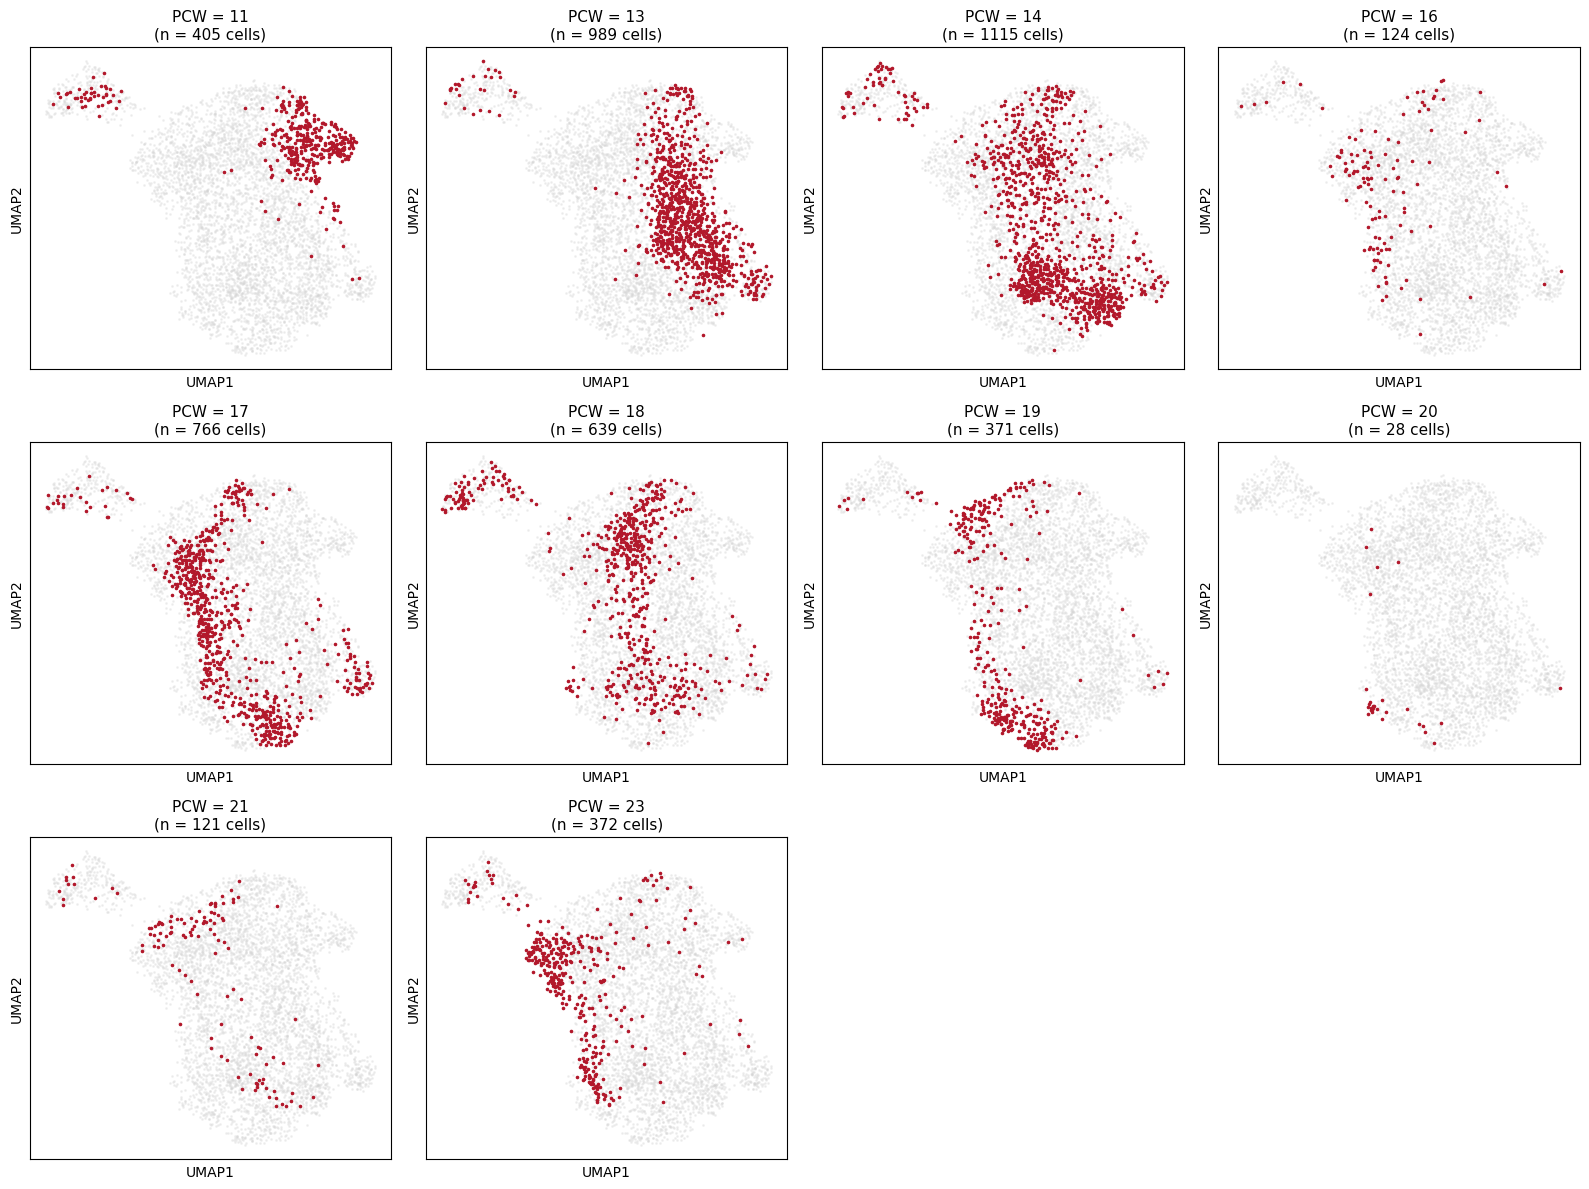

In [12]:
## 11) plot
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

# 1️⃣ 确保 pcw 是数值
adata.obs["pcw"] = adata.obs["pcw"].astype(float)

# 2️⃣ 获取所有 pcw（排序）
pcw_list = np.sort(adata.obs["pcw"].unique())

n = len(pcw_list)
ncols = 4
nrows = int(np.ceil(n / ncols))

plt.figure(figsize=(4 * ncols, 4 * nrows))

for i, pcw in enumerate(pcw_list):
    ax = plt.subplot(nrows, ncols, i + 1)

    # 3️⃣ 背景：plot 所有细胞（灰色）
    sc.pl.umap(
        adata,
        color=None,
        size=5,
        alpha=0.25,
        ax=ax,
        show=False
    )
    ax.collections[-1].set_color("lightgrey")

    # 4️⃣ 前景：当前 PCW = pcw 的 subset（红色）
    ad_sub = adata[adata.obs["pcw"] == pcw].copy()

    sc.pl.umap(
        ad_sub,
        color=None,
        size=10,
        alpha=1.0,
        ax=ax,
        show=False
    )
    ax.collections[-1].set_color("#b2182b")   # deep red

    # 5️⃣ 英文标题 + cell 数
    count = ad_sub.n_obs
    ax.set_title(f"PCW = {int(pcw)}\n(n = {count} cells)", fontsize=11)

    # 6️⃣ 去掉坐标轴
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("umap_each_pcw_adata.pdf", dpi=300, bbox_inches="tight")
plt.show()



### 1.3 Split into Training and Test Sets

The dataset contains a pre-defined `source` column indicating train/test split. We separate and save them for model training and evaluation.

In [13]:
# Split by source column
train_adata = adata[adata.obs['source'] == 'train'].copy()
test_adata = adata[adata.obs['source'] == 'test'].copy()

print(f"Dataset Split:")
print(f"  Training set: {train_adata.n_obs} cells")
print(f"  Test set: {test_adata.n_obs} cells")

# Analyze PCW distribution in each split
train_pcw = train_adata.obs['pcw'].astype(float).values
test_pcw = test_adata.obs['pcw'].astype(float).values

print(f"\nTraining Set PCW Distribution:")
print(f"  Early (PCW < 15): {np.sum(train_pcw < 15)} cells")
print(f"  Late (PCW > 18): {np.sum(train_pcw > 18)} cells")
print(f"  Target range (15-18): {np.sum((train_pcw >= 15) & (train_pcw <= 18))} cells")

print(f"\nTest Set PCW Distribution:")
print(f"  Target range (15-18): {np.sum((test_pcw >= 15) & (test_pcw <= 18))} cells")
print(f"  Other ranges: {np.sum((test_pcw < 15) | (test_pcw > 18))} cells")

Dataset Split:
  Training set: 3401 cells
  Test set: 1529 cells

Training Set PCW Distribution:
  Early (PCW < 15): 2509 cells
  Late (PCW > 18): 892 cells
  Target range (15-18): 0 cells

Test Set PCW Distribution:
  Target range (15-18): 1529 cells
  Other ranges: 0 cells


### 1.4 Save Prepared Data

Save the train/test splits to disk for model training and inference.

In [14]:
# Create output directory
os.makedirs("./development_data", exist_ok=True)

# Define output paths
train_path = "./development_data/train_300genes.h5ad"
test_path = "./development_data/test_300genes.h5ad"

# Save to disk
train_adata.write_h5ad(train_path)
test_adata.write_h5ad(test_path)

print(f"✅ Data preparation complete!")
print(f"  Training data saved to: {train_path}")
print(f"  Test data saved to: {test_path}")

# Store number of genes for later use
n_genes = adata.n_vars
print(f"\nNumber of genes: {n_genes}")

✅ Data preparation complete!
  Training data saved to: ./development_data/train_300genes.h5ad
  Test data saved to: ./development_data/test_300genes.h5ad

Number of genes: 300


---
## 2. Model Training

### 2.1 Configure Training Arguments

Set up hyperparameters for the Squidiff diffusion model. Key configurations:
- **Model architecture**: 3-layer MLP with 256 hidden units, 64-dim latent space
- **Regularization**: Dropout (0.1) + Weight decay (1e-4) to prevent overfitting
- **Training**: 20k steps with learning rate 1e-4
- **Diffusion**: 1000-step forward process

## Q2.1: Please test different parameter setting and report the final result and testing metrics. You may duplicate multiple JupiterNotebook to finsih these tasks.
##       Test the following mertic lr from [1e-3,1e-4,5e-5].
## Q2.2: Test lr = 1e-4, weight_decay = 1e-4, and report the final result and testing metrics.
## Q2.2: Test lr = 1e-4, weight_decay = 1e-4, dropout = 0.1, and report the final result and testing metrics.
## Q2.3: Conclude the findings.

In [17]:
# Setup training arguments programmatically
sys.argv = [
    'notebook',
    '--data_path', train_path,
    '--logger_path', './development_results/logs',
    '--resume_checkpoint', './development_results/models',
    '--gene_size', str(n_genes),
    '--output_dim', str(n_genes),
    '--lr', '0.0001',
    '--batch_size', '32',
    '--log_interval', '100',
    '--save_interval', '1000',
    '--lr_anneal_steps', '20000',
    '--weight_decay', '0',
    '--dropout', '0',
]

print("Training Configuration:")
print(f"  Gene size: {n_genes}")
print(f"  Learning rate: {sys.argv[12]}")
print(f"  Batch size: {sys.argv[14]}")
print(f"  Total steps: {sys.argv[20]}")
print(f"  Weight decay: {sys.argv[22]}")
print(f"  Dropout: {sys.argv[24]}")

Training Configuration:
  Gene size: 300
  Learning rate: 0.0001
  Batch size: 32
  Total steps: 20000
  Weight decay: 0
  Dropout: 0


---
### 2.2 Create Output Directories and Run Training

Prepare directories for saving model checkpoints and training logs, then execute the training process.

**Note**: This step may take 120 minutes depending on hardware (GPU highly recommended).

Starting model training...
Logging to ./development_results/logs
*********creating model and diffusion**********
creating data loader...
**********training started at 2025-11-19 23:37:29.351107 **********
-------------------------
| grad_norm  | 1.84     |
| loss       | 1.12     |
| loss_q0    | 1.16     |
| loss_q1    | 1.15     |
| loss_q2    | 1.09     |
| loss_q3    | 1.07     |
| mse        | 1.12     |
| mse_q0     | 1.16     |
| mse_q1     | 1.15     |
| mse_q2     | 1.09     |
| mse_q3     | 1.07     |
| param_norm | 172      |
| samples    | 32       |
| step       | 0        |
-------------------------
saving model 0...
saving model 0.9999...
-------------------------
| grad_norm  | 1        |
| loss       | 0.901    |
| loss_q0    | 0.951    |
| loss_q1    | 0.892    |
| loss_q2    | 0.882    |
| loss_q3    | 0.879    |
| mse        | 0.901    |
| mse_q0     | 0.951    |
| mse_q1     | 0.892    |
| mse_q2     | 0.882    |
| mse_q3     | 0.879    |
| param_norm | 172      |


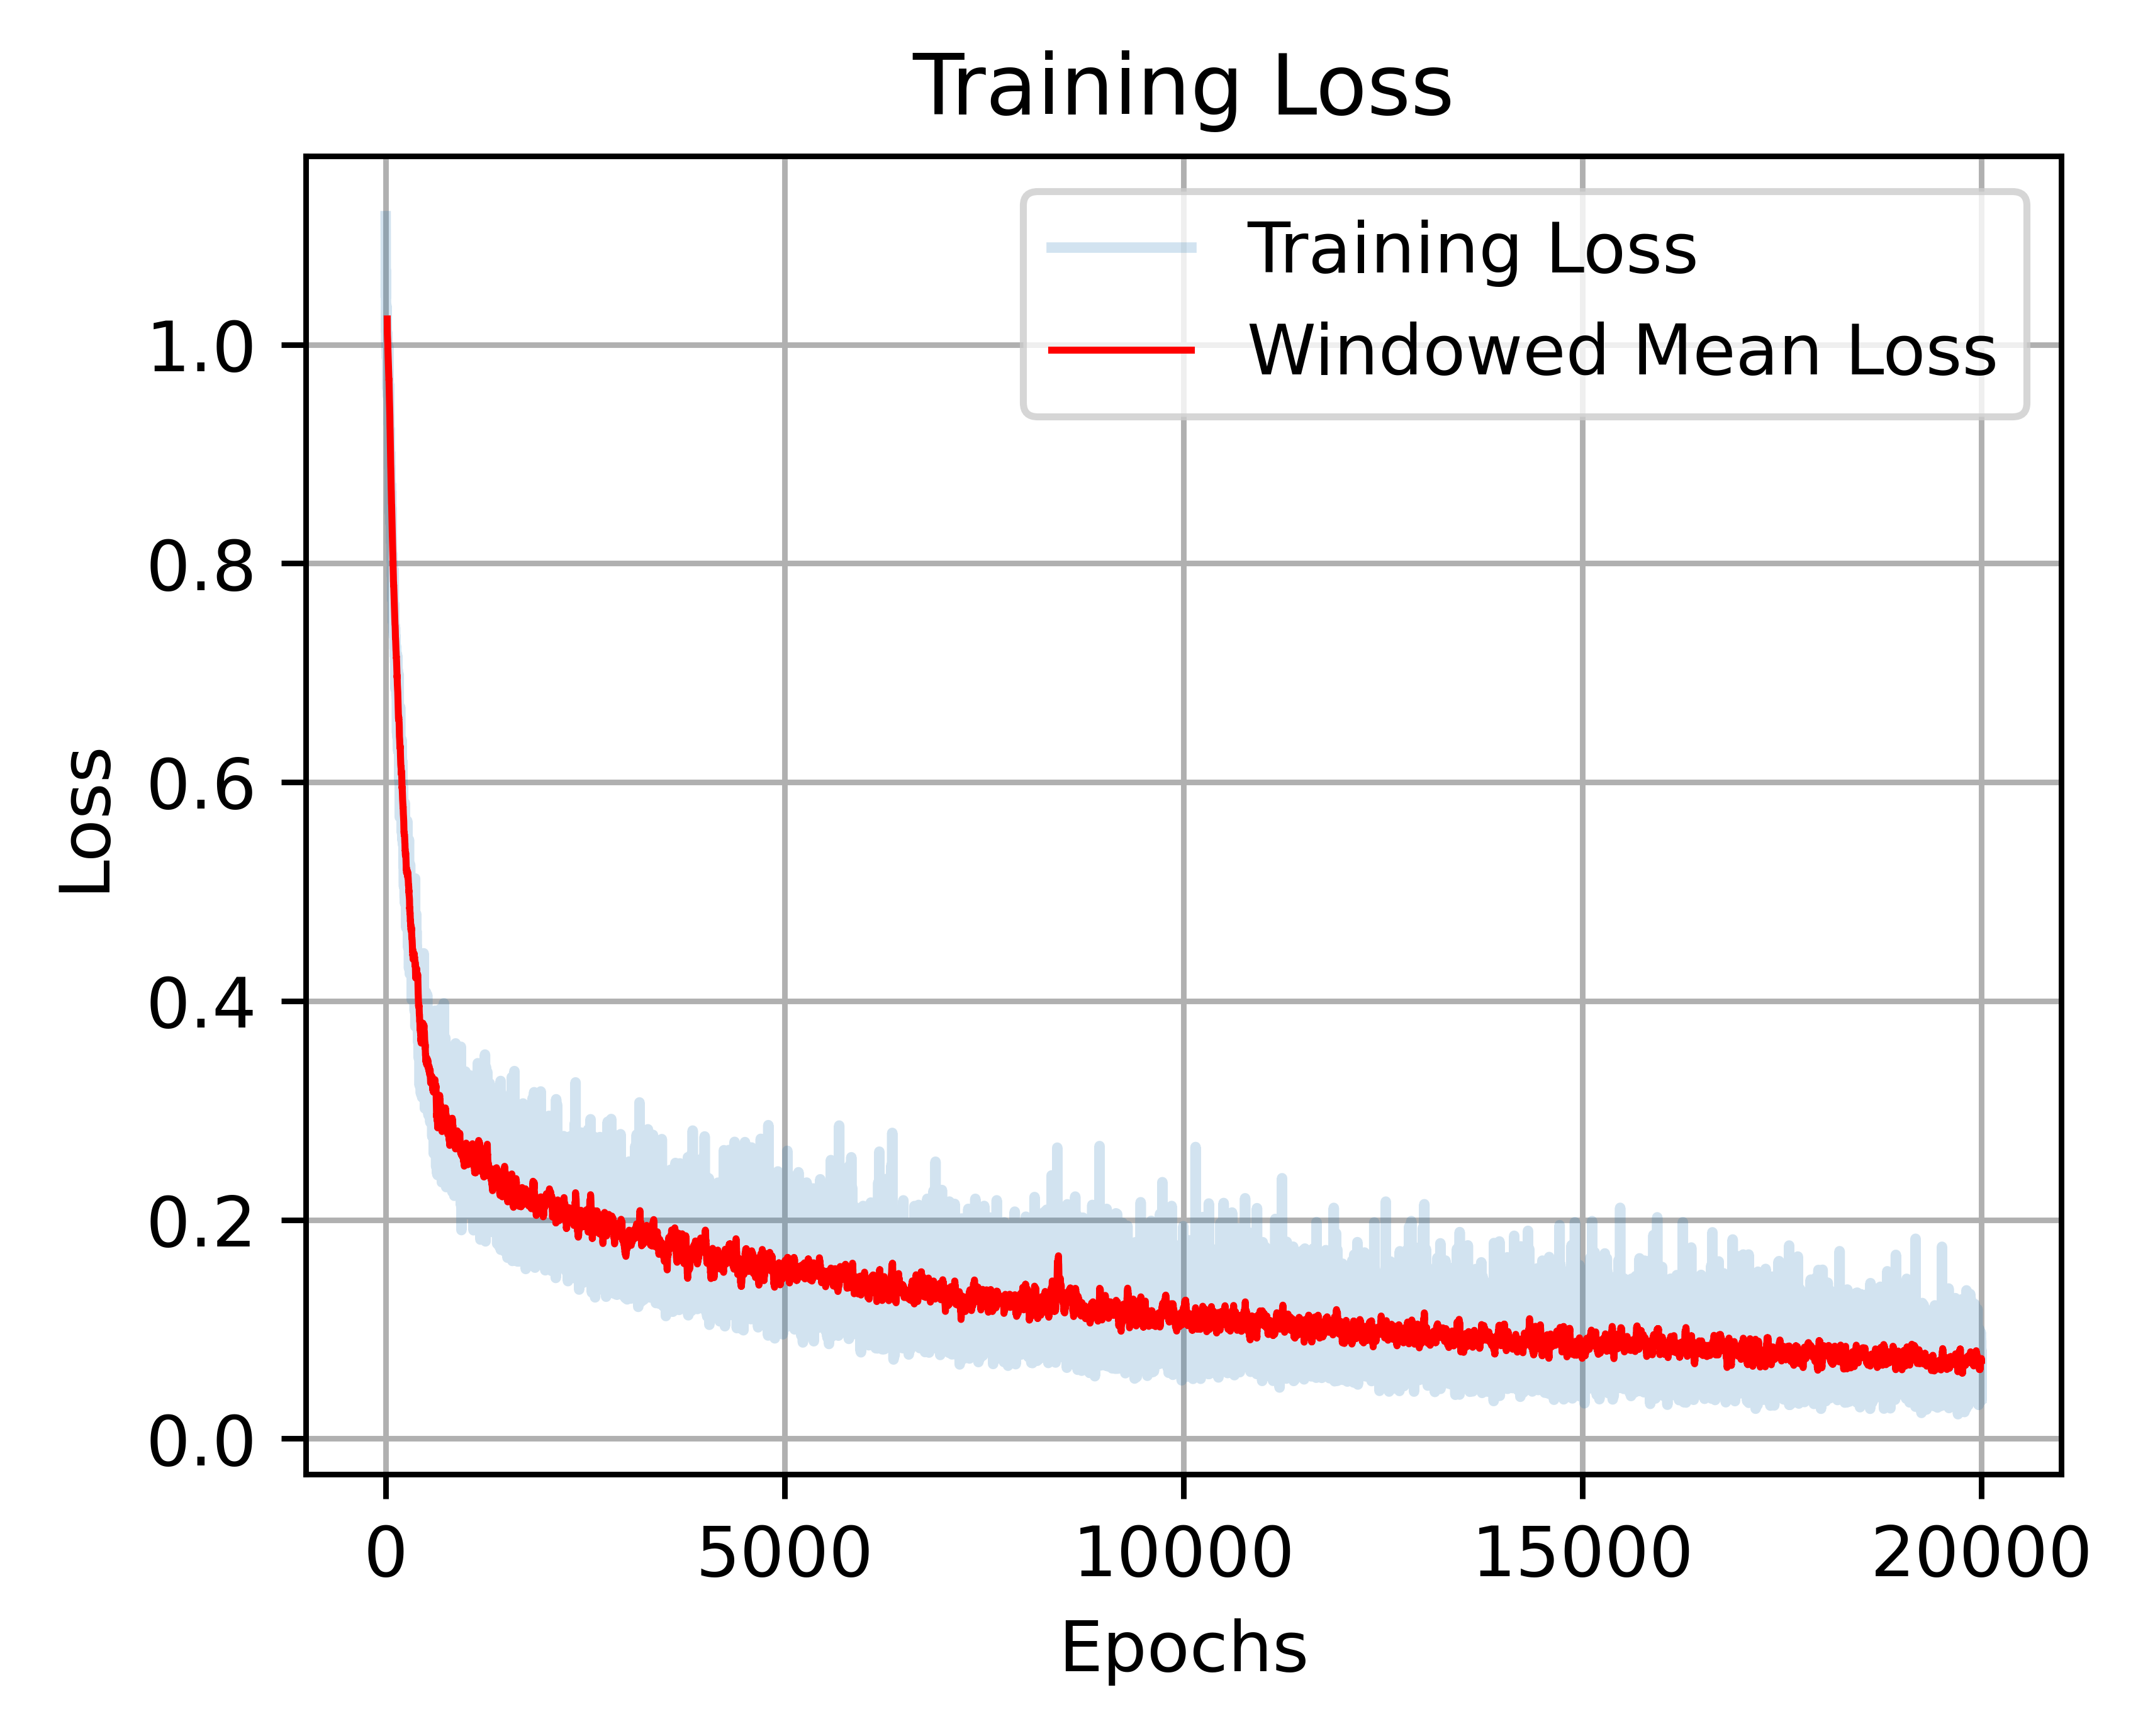

In [18]:
# Create directories
os.makedirs('./development_results/models', exist_ok=True)
os.makedirs('./development_results/logs', exist_ok=True)

# Import and run training
from Squidiff.train_development import parse_args, run_training, plot_loss

print("Starting model training...")
args_train = parse_args()
losses = run_training(args_train)
plot_loss(losses, args_train)

print("\n✅ Training complete!")
model_path = './development_results/models/model.pt'
print(f"Model saved to: {model_path}")

---
## 3. Inference via Latent Space Interpolation

### 3.1 Load Data and Model

We use a **latent space interpolation** approach:
1. Encode stage 1 (PCW<15) and stage 3 (PCW>18) cells to latent space
2. Compute developmental direction vector
3. Interpolate test cells (stage 2) along this direction

In [20]:
print("Loading data for inference...")
train_adata = sc.read_h5ad(train_path)
test_adata = sc.read_h5ad(test_path)
print(f"  Training: {train_adata.shape}, Test: {test_adata.shape}")

Loading data for inference...
  Training: (3401, 300), Test: (1529, 300)


### 3.2 Filter Cells by Developmental Stage

In [21]:
train_pcw = train_adata.obs['pcw'].astype(float).values
test_pcw = test_adata.obs['pcw'].astype(float).values

train_low = train_adata[train_pcw < 15].copy()
train_high = train_adata[train_pcw > 18].copy()
test_target = test_adata[(test_pcw >= 16) & (test_pcw <= 18)].copy()

print(f"Early (PCW<15): {train_low.n_obs}, Late (PCW>18): {train_high.n_obs}")
print(f"Target test (15≤PCW≤18): {test_target.n_obs}")

Early (PCW<15): 2509, Late (PCW>18): 892
Target test (15≤PCW≤18): 1529


### 3.3 Load Trained Model

In [24]:
print("Loading trained model...")
import torch
from Squidiff import dist_util
from Squidiff.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    args_to_dict,
)

# load model metrics
model_args = {
    'gene_size': 300,
    'output_dim': 300,
    'num_layers': 3,
    'num_channels': 128,
    'dropout': 0.0,
    'class_cond': False,
    'use_encoder': True,
    'use_drug_structure': False,
    'drug_dimension': 1024,
    'comb_num': 1,
    'hidden_sizes': 2048,
    'latent_dim': 60,
    'learn_sigma': False,
    'diffusion_steps': 1000,
    'noise_schedule': 'linear',
    'timestep_respacing': '',
    'use_kl': False,
    'predict_xstart': False,
    'rescale_timesteps': False,
    'rescale_learned_sigmas': False,
    'use_checkpoint': False,
    'use_scale_shift_norm': True,
    'use_fp16': False,
}

model, diffusion = create_model_and_diffusion(**model_args)

# load model
model_path = './development_results/models/model.pt'
state_dict = dist_util.load_state_dict(model_path, map_location=dist_util.dev())
model.load_state_dict(state_dict)
model.to(dist_util.dev())
model.eval()

print(f"✅ Model loaded from: {model_path}")


Loading trained model...
✅ Model loaded from: ./development_results/models/model.pt


### 3.4 Encode Training Cells to Latent Space

In [25]:

print("Encoding training cells to latent space...")

train_low_X = train_low.X.toarray() if hasattr(train_low.X, 'toarray') else train_low.X
train_high_X = train_high.X.toarray() if hasattr(train_high.X, 'toarray') else train_high.X

train_low_tensor = torch.tensor(train_low_X, dtype=torch.float32).to(dist_util.dev())
train_high_tensor = torch.tensor(train_high_X, dtype=torch.float32).to(dist_util.dev())

with torch.no_grad():
    z_sem_low = model.encoder(train_low_tensor, label=None, drug_dose=None, control_feature=None)
    z_sem_high = model.encoder(train_high_tensor, label=None, drug_dose=None, control_feature=None)

print(f"Early latent: {z_sem_low.shape}, Late latent: {z_sem_high.shape}")

Encoding training cells to latent space...
Early latent: torch.Size([2509, 60]), Late latent: torch.Size([892, 60])


### 3.5 Compute Differentiation Direction Vector

In [26]:
print("Computing differentiation direction...")
direct_z_sem = z_sem_high.mean(axis=0) - z_sem_low.mean(axis=0)
print(f"Direction: {direct_z_sem.shape}, Norm: {torch.norm(direct_z_sem).item():.4f}")

Computing differentiation direction...
Direction: torch.Size([60]), Norm: 0.4416


### 3.6 Encode Test Cells and Interpolate

In [27]:
print("Encoding test cells...")
test_X = test_target.X.toarray() if hasattr(test_target.X, 'toarray') else test_target.X
test_features = torch.tensor(test_X, dtype=torch.float32).to(dist_util.dev())

##stage 3 - state 1
with torch.no_grad():
    z_sem_test = model.encoder(test_features, label=None, drug_dose=None, control_feature=None)

print(f"Test latent: {z_sem_test.shape}")

Encoding test cells...
Test latent: torch.Size([1529, 60])


### 3.7 Latent Space Interpolation
## Assuming the interpolation fit a linear modoel
## stage 2 = scale * (stage 3 - stage 1)
Move test cells halfway (scale=0.5) along the differentiation direction and add Gaussian noise.

In [28]:
scale = 0.5
noise_scale = 0.7

z_sem_test_np = z_sem_test.detach().cpu().numpy()
z_sem_mean = z_sem_test_np.mean(axis=0)
z_sem_interp_mean = z_sem_mean + direct_z_sem.detach().cpu().numpy() * scale

def sample_around_point(point, num_samples, noise_scale=0.7):
    return point + noise_scale * np.random.randn(num_samples, point.shape[0])

z_sem_interp = sample_around_point(z_sem_interp_mean, len(test_features), noise_scale)
z_sem_interp_tensor = torch.tensor(z_sem_interp, dtype=torch.float32).to(dist_util.dev())

print(f"Interpolated latent: {z_sem_interp_tensor.shape}")

Interpolated latent: torch.Size([1529, 60])


### 3.8 Generate Predictions via Diffusion Sampling

In [29]:
print("Generating predictions...")

# Use DDPM sampling (p_sample_loop) for full 1000 steps
sample_fn = diffusion.p_sample_loop  # Use DDPM
batch_size = 100
all_predictions = []

with torch.no_grad():
    for i in range(0, len(test_features), batch_size):
        end_idx = min(i + batch_size, len(test_features))
        batch_z_sem = z_sem_interp_tensor[i:end_idx]
        
        batch_pred = sample_fn(
            model,
            shape=(end_idx - i, n_genes),
            model_kwargs={'z_mod': batch_z_sem},
            noise=None,
            clip_denoised=True,
            progress=False,
        )
        all_predictions.append(batch_pred)
        
        if (i // batch_size) % 5 == 0:
            print(f"  {end_idx}/{len(test_features)} cells")

predictions = torch.cat(all_predictions, dim=0)
print(f"\nPredictions: {predictions.shape}")

Generating predictions...
  100/1529 cells
  600/1529 cells
  1100/1529 cells
  1529/1529 cells

Predictions: torch.Size([1529, 300])


---
## 4. Performance Evaluation

### 4.1 Calculate Metrics

In [41]:
if isinstance(predictions, torch.Tensor):
    pred_numpy = predictions.detach().cpu().numpy()
else:
    pred_numpy = predictions

true_numpy = test_X

def chatterjee_corr(x, y):
    n = len(x)
    if n < 2:
        return 0.0
    order = np.argsort(x)
    y_ordered = y[order]
    ranks = rankdata(y_ordered, method='ordinal')
    diff = np.abs(np.diff(ranks))
    return 1 - (3 * diff.sum()) / (n**2 - 1)

#  (mean across genes for each cell)
pred_mean = pred_numpy.mean(axis=1)  # shape: (n_cells,)
true_mean = true_numpy.mean(axis=1)  # shape: (n_cells,)

# 
valid_mask = np.isfinite(pred_mean) & np.isfinite(true_mean)
pred_clean = pred_mean[valid_mask]
true_clean = true_mean[valid_mask]

metrics = {
    'mse': float(mean_squared_error(true_clean, pred_clean)),
    'mae': float(mean_absolute_error(true_clean, pred_clean)),
    'rmse': float(np.sqrt(mean_squared_error(true_clean, pred_clean))),
    'pearson': float(pearsonr(true_clean, pred_clean)[0]),
    'spearman': float(spearmanr(true_clean, pred_clean)[0]),
    'chatterjee': float(chatterjee_corr(true_clean, pred_clean)),
}

print("\n" + "="*50)
print("📊 PERFORMANCE METRICS (Cell-level Mean Expression)")
print("="*50)
for k, v in metrics.items():
    print(f"  {k.upper():15s}: {v:.6f}")
print("="*50)



📊 PERFORMANCE METRICS (Cell-level Mean Expression)
  MSE            : 0.021770
  MAE            : 0.133012
  RMSE           : 0.147546
  PEARSON        : 0.004016
  SPEARMAN       : -0.002728
  CHATTERJEE     : -0.001360


### 4.2 Save Results

In [42]:
os.makedirs("./inference_results", exist_ok=True)

result_adata = test_target.copy()
result_adata.obsm['predictions'] = pred_numpy
result_adata.obsm['original'] = true_numpy
result_adata.write_h5ad("./inference_results/predictions.h5ad")

with open("./inference_results/metrics.json", 'w') as f:
    json.dump(metrics, f, indent=2)

print("✅ Results saved to ./inference_results/")

✅ Results saved to ./inference_results/


---
## 5. Distribution Analysis

### 5.1 Compute MMD and Energy Distance

In [43]:
result_adata = sc.read_h5ad("./inference_results/predictions.h5ad")
predictions = result_adata.obsm['predictions']
original = result_adata.obsm['original']

# Subsample for efficiency
np.random.seed(42)
if predictions.shape[0] > 2000:
    idx = np.random.choice(predictions.shape[0], 2000, replace=False)
    pred_sub = predictions[idx]
    orig_sub = original[idx]
else:
    pred_sub = predictions
    orig_sub = original

def compute_mmd_rbf(X, Y):
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)
    dists = pdist(X)
    sigma = np.median(dists) if len(dists) > 0 else 1.0
    
    def rbf_kernel(A, B):
        dist_sq = np.sum(A**2, axis=1, keepdims=True) + np.sum(B**2, axis=1) - 2 * np.dot(A, B.T)
        return np.exp(-dist_sq / (2 * sigma**2))
    
    n, m = X.shape[0], Y.shape[0]
    K_XX = rbf_kernel(X, X)
    K_YY = rbf_kernel(Y, Y)
    K_XY = rbf_kernel(X, Y)
    
    return float(np.sum(K_XX)/(n*n) + np.sum(K_YY)/(m*m) - 2*np.sum(K_XY)/(n*m))

mmd_value = compute_mmd_rbf(orig_sub, pred_sub)
e_dist = float(energy_distance(orig_sub.flatten(), pred_sub.flatten()))

dist_metrics = {'MMD_RBF': mmd_value, 'E_distance': e_dist}

print("\n" + "="*50)
print("📊 DISTRIBUTION METRICS")
print("="*50)
print(f"  MMD (RBF):        {mmd_value:.6f}")
print(f"  Energy distance:  {e_dist:.6f}")
print("="*50)


📊 DISTRIBUTION METRICS
  MMD (RBF):        0.184446
  Energy distance:  0.417901


### 5.2 Save Distribution Metrics

In [44]:
with open("./inference_results/distribution_metrics.json", 'w') as f:
    json.dump(dist_metrics, f, indent=2)

print("✅ Distribution metrics saved")

✅ Distribution metrics saved


---
## 6. Visualization: Predicted vs Real

### 6.1 Diagonal Scatter Plot (Predicted vs Real)

Creating diagonal scatter plot...


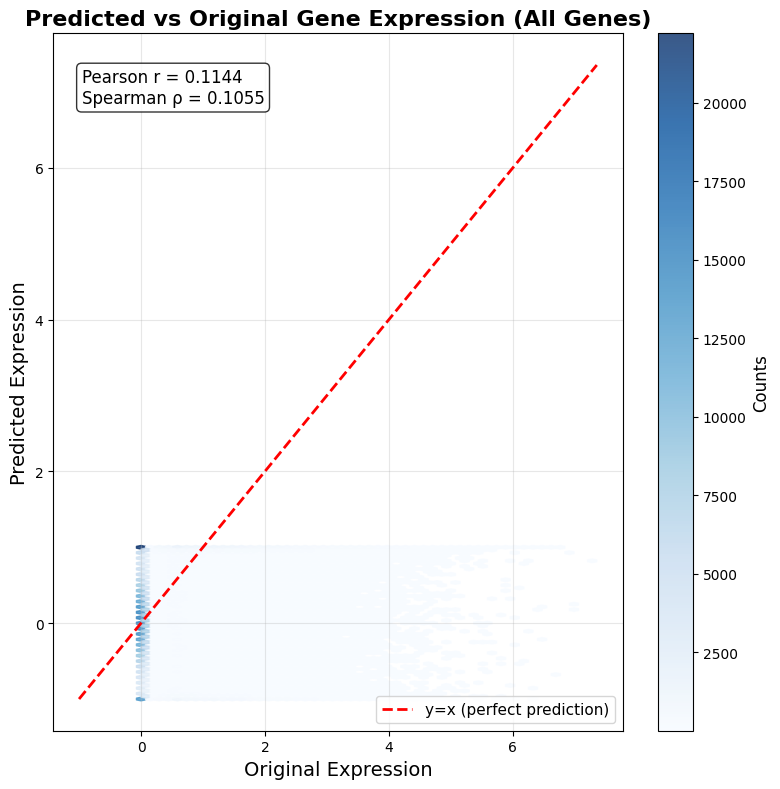

✅ Diagonal scatter plot saved
  Pearson correlation: 0.1144
  Spearman correlation: 0.1055


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
result_adata = sc.read_h5ad("./inference_results/predictions.h5ad")
predictions = result_adata.obsm['predictions']
original = result_adata.obsm['original']

print("Creating diagonal scatter plot...")

# Flatten arrays for plotting
pred_flat = predictions.flatten()
orig_flat = original.flatten()

# Create scatter plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Hexbin plot for better visualization of density
hb = ax.hexbin(orig_flat, pred_flat, gridsize=50, cmap='Blues', mincnt=1, alpha=0.8)
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Counts', fontsize=12)

# Add diagonal line (y=x)
min_val = min(orig_flat.min(), pred_flat.min())
max_val = max(orig_flat.max(), pred_flat.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='y=x (perfect prediction)')

# Add correlation text
pearson_r = pearsonr(orig_flat, pred_flat)[0]
spearman_r = spearmanr(orig_flat, pred_flat)[0]
ax.text(0.05, 0.95, f'Pearson r = {pearson_r:.4f}\nSpearman ρ = {spearman_r:.4f}', 
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('Original Expression', fontsize=14)
ax.set_ylabel('Predicted Expression', fontsize=14)
ax.set_title('Predicted vs Original Gene Expression (All Genes)', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./inference_results/diagonal_scatter_plot.pdf", dpi=300, bbox_inches='tight')
plt.savefig("./inference_results/diagonal_scatter_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Diagonal scatter plot saved")
print(f"  Pearson correlation: {pearson_r:.4f}")
print(f"  Spearman correlation: {spearman_r:.4f}")

### 6.2 Top Correlated Genes Analysis

In [35]:
print("Computing per-gene correlations...")

# Compute correlation for each gene
n_genes = predictions.shape[1]
gene_correlations = []

for i in range(n_genes):
    pred_gene = predictions[:, i]
    orig_gene = original[:, i]
    
    # Only compute if there's variation
    if pred_gene.std() > 0 and orig_gene.std() > 0:
        corr, _ = pearsonr(pred_gene, orig_gene)
        gene_correlations.append({
            'gene_idx': i,
            'gene_name': result_adata.var_names[i] if hasattr(result_adata, 'var_names') else f'Gene_{i}',
            'pearson': corr,
            'mean_pred': pred_gene.mean(),
            'mean_orig': orig_gene.mean(),
            'std_pred': pred_gene.std(),
            'std_orig': orig_gene.std()
        })
    else:
        gene_correlations.append({
            'gene_idx': i,
            'gene_name': result_adata.var_names[i] if hasattr(result_adata, 'var_names') else f'Gene_{i}',
            'pearson': 0.0,
            'mean_pred': pred_gene.mean(),
            'mean_orig': orig_gene.mean(),
            'std_pred': pred_gene.std(),
            'std_orig': orig_gene.std()
        })

# Convert to DataFrame
import pandas as pd
gene_corr_df = pd.DataFrame(gene_correlations)
gene_corr_df = gene_corr_df.sort_values('pearson', ascending=False)

# Display top 20 genes
print("\n" + "="*80)
print("TOP 20 GENES BY PEARSON CORRELATION")
print("="*80)
print(gene_corr_df.head(20).to_string(index=False))
print("="*80)

# Display bottom 20 genes (worst predictions)
print("\n" + "="*80)
print("BOTTOM 20 GENES BY PEARSON CORRELATION (Worst Predictions)")
print("="*80)
print(gene_corr_df.tail(20).to_string(index=False))
print("="*80)

# Save to CSV
gene_corr_df.to_csv("./inference_results/gene_correlations.csv", index=False)
print("\n✅ Gene correlations saved to ./inference_results/gene_correlations.csv")

# Summary statistics
print("\n" + "="*50)
print("CORRELATION SUMMARY STATISTICS")
print("="*50)
print(f"  Mean correlation:   {gene_corr_df['pearson'].mean():.4f}")
print(f"  Median correlation: {gene_corr_df['pearson'].median():.4f}")
print(f"  Std correlation:    {gene_corr_df['pearson'].std():.4f}")
print(f"  Max correlation:    {gene_corr_df['pearson'].max():.4f}")
print(f"  Min correlation:    {gene_corr_df['pearson'].min():.4f}")
print(f"  Genes with r > 0.5: {(gene_corr_df['pearson'] > 0.5).sum()}")
print(f"  Genes with r > 0.3: {(gene_corr_df['pearson'] > 0.3).sum()}")
print(f"  Genes with r < 0:   {(gene_corr_df['pearson'] < 0).sum()}")
print("="*50)

Computing per-gene correlations...

TOP 20 GENES BY PEARSON CORRELATION
 gene_idx gene_name  pearson  mean_pred  mean_orig  std_pred  std_orig
      175   ZFAND2A 0.084357   0.065512   0.277613  0.802866  0.493758
      123     PRAC1 0.071156  -0.003030   0.190944  0.670020  0.480855
      127      TFF1 0.064112   0.159805   0.228693  0.587632  0.477276
      194       CCK 0.054997   0.047236   0.000538  0.380481  0.017165
      126    LRRC36 0.053316   0.092387   0.001989  0.368009  0.032377
       16       AFP 0.044650   0.138556   0.569738  0.818282  0.746272
       82       PYY 0.043092   0.066198   0.057918  0.487697  0.340750
       86     NR0B2 0.042399   0.079518   0.257522  0.795397  0.501147
        5   LGALS14 0.041922   0.057688   0.349764  0.845106  0.599896
      102      EMP3 0.041591   0.149517   0.075614  0.462463  0.284382
      143       CA3 0.039207  -0.027797   0.035279  0.458715  0.201916
      120      CPA2 0.038525  -0.017511   0.006581  0.359755  0.092090
     

### 6.3 Visualize Top Correlated Genes

Plotting top 16 correlated genes...


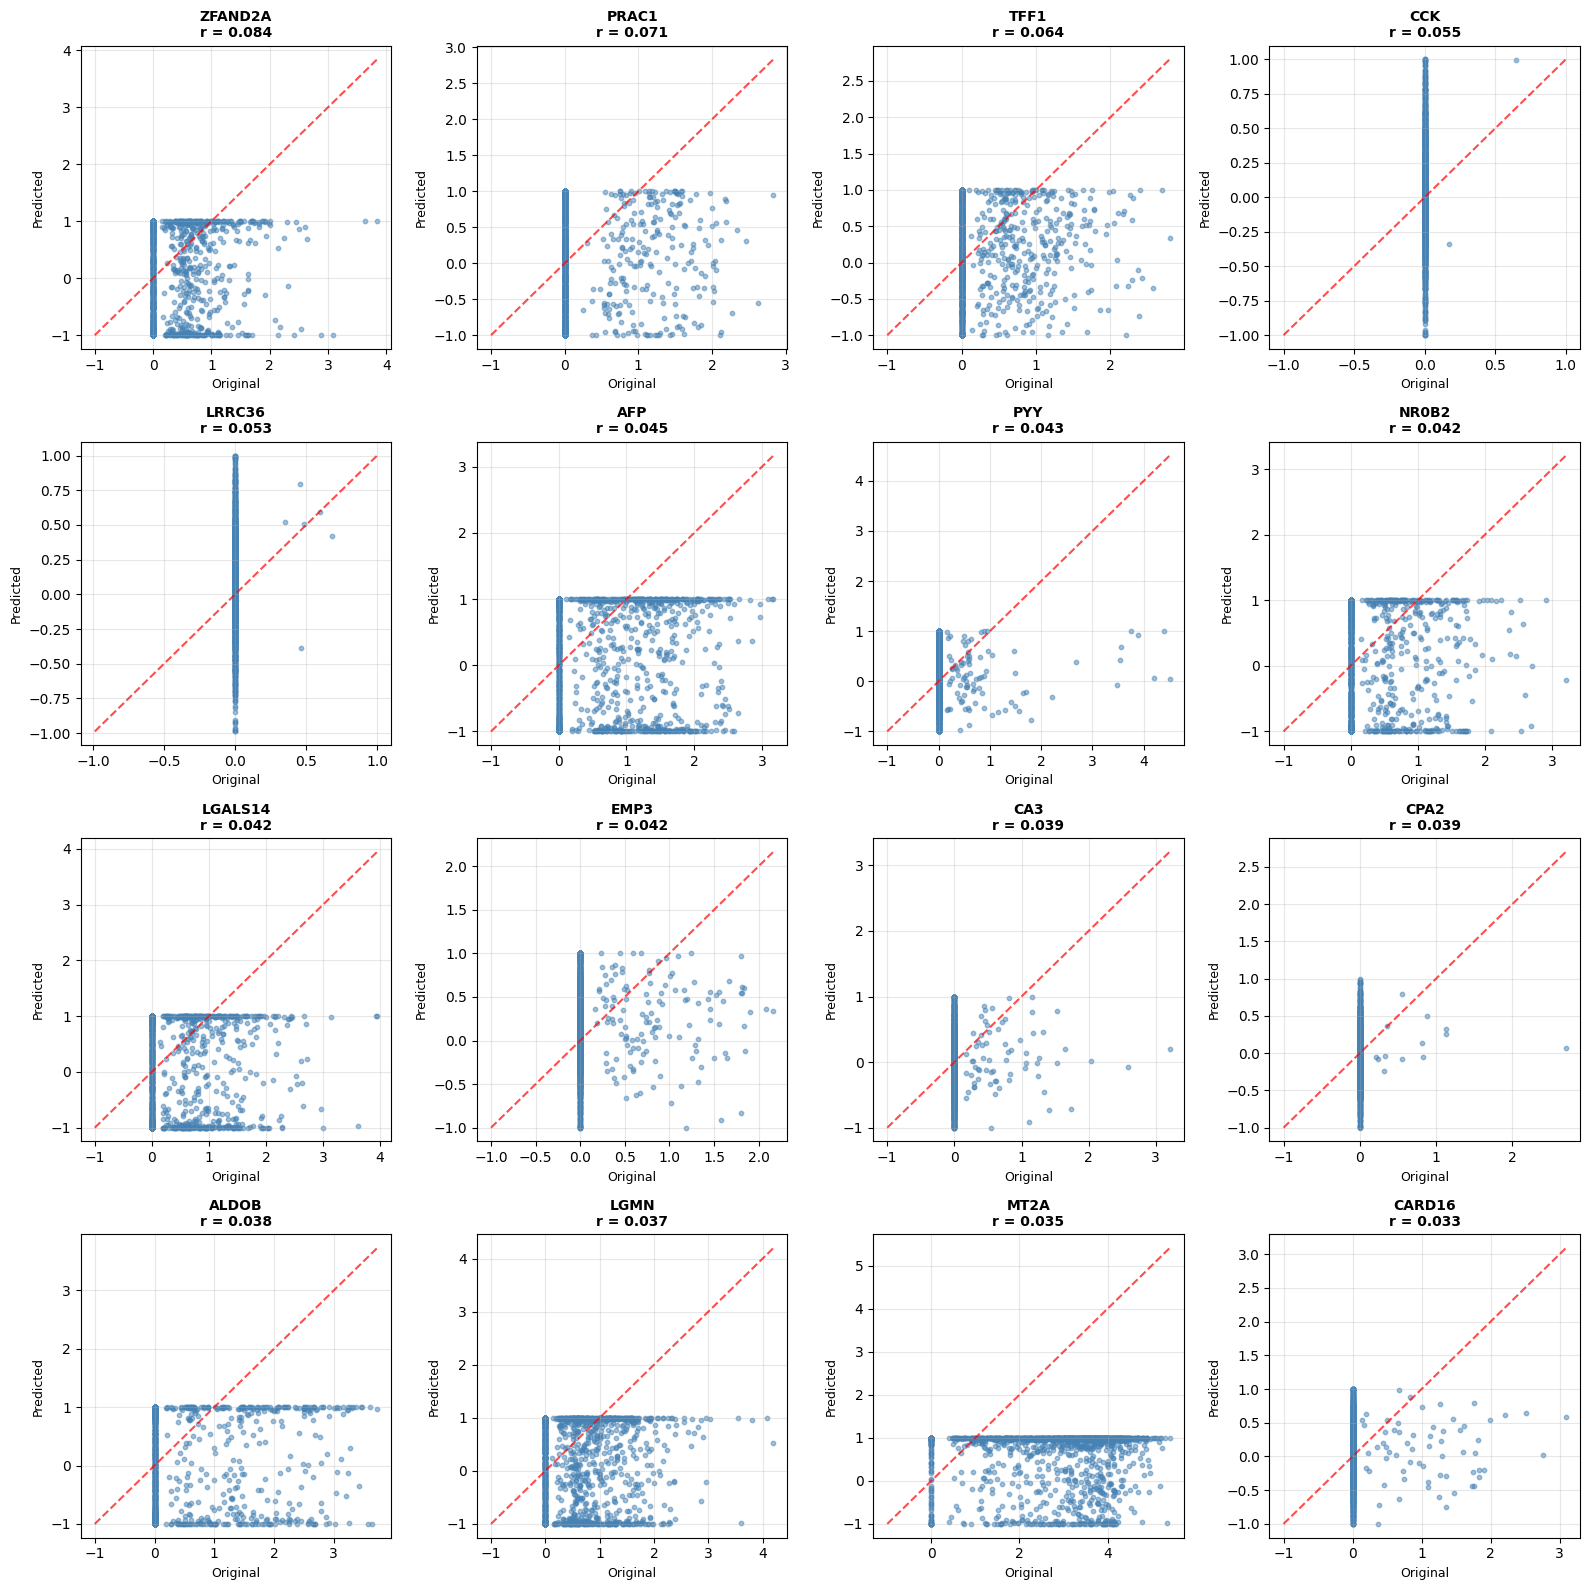

✅ Top 16 genes scatter plots saved


In [36]:
print("Plotting top 16 correlated genes...")

# Get top 16 genes
top_genes = gene_corr_df.head(16)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for idx, (i, row) in enumerate(top_genes.iterrows()):
    ax = axes[idx]
    gene_idx = row['gene_idx']
    gene_name = row['gene_name']
    corr = row['pearson']
    
    pred_gene = predictions[:, gene_idx]
    orig_gene = original[:, gene_idx]
    
    # Scatter plot
    ax.scatter(orig_gene, pred_gene, alpha=0.5, s=10, c='steelblue')
    
    # Diagonal line
    min_val = min(orig_gene.min(), pred_gene.min())
    max_val = max(orig_gene.max(), pred_gene.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5, alpha=0.7)
    
    # Add title with correlation
    ax.set_title(f'{gene_name}\nr = {corr:.3f}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Original', fontsize=9)
    ax.set_ylabel('Predicted', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./inference_results/top16_genes_scatter.pdf", dpi=300, bbox_inches='tight')
plt.savefig("./inference_results/top16_genes_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Top 16 genes scatter plots saved")

### 6.4 UMAP Visualization: Predicted vs Original Distribution

In [37]:
print("Computing UMAP embeddings for predicted and original data...")

# Create AnnData objects for UMAP
import scanpy as sc

# Original data
adata_orig = sc.AnnData(X=original)
adata_orig.obs['data_type'] = 'Original'
adata_orig.obs['pcw'] = result_adata.obs['pcw'].values

# Predicted data
adata_pred = sc.AnnData(X=predictions)
adata_pred.obs['data_type'] = 'Predicted'
adata_pred.obs['pcw'] = result_adata.obs['pcw'].values

# Compute PCA and UMAP for original
print("  Computing UMAP for original data...")
sc.tl.pca(adata_orig, svd_solver='arpack')
sc.pp.neighbors(adata_orig, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata_orig)

# Compute PCA and UMAP for predicted
print("  Computing UMAP for predicted data...")
sc.tl.pca(adata_pred, svd_solver='arpack')
sc.pp.neighbors(adata_pred, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata_pred)

print("✅ UMAP embeddings computed")

Computing UMAP embeddings for predicted and original data...
  Computing UMAP for original data...
  Computing UMAP for predicted data...
✅ UMAP embeddings computed


Plotting UMAP comparison...


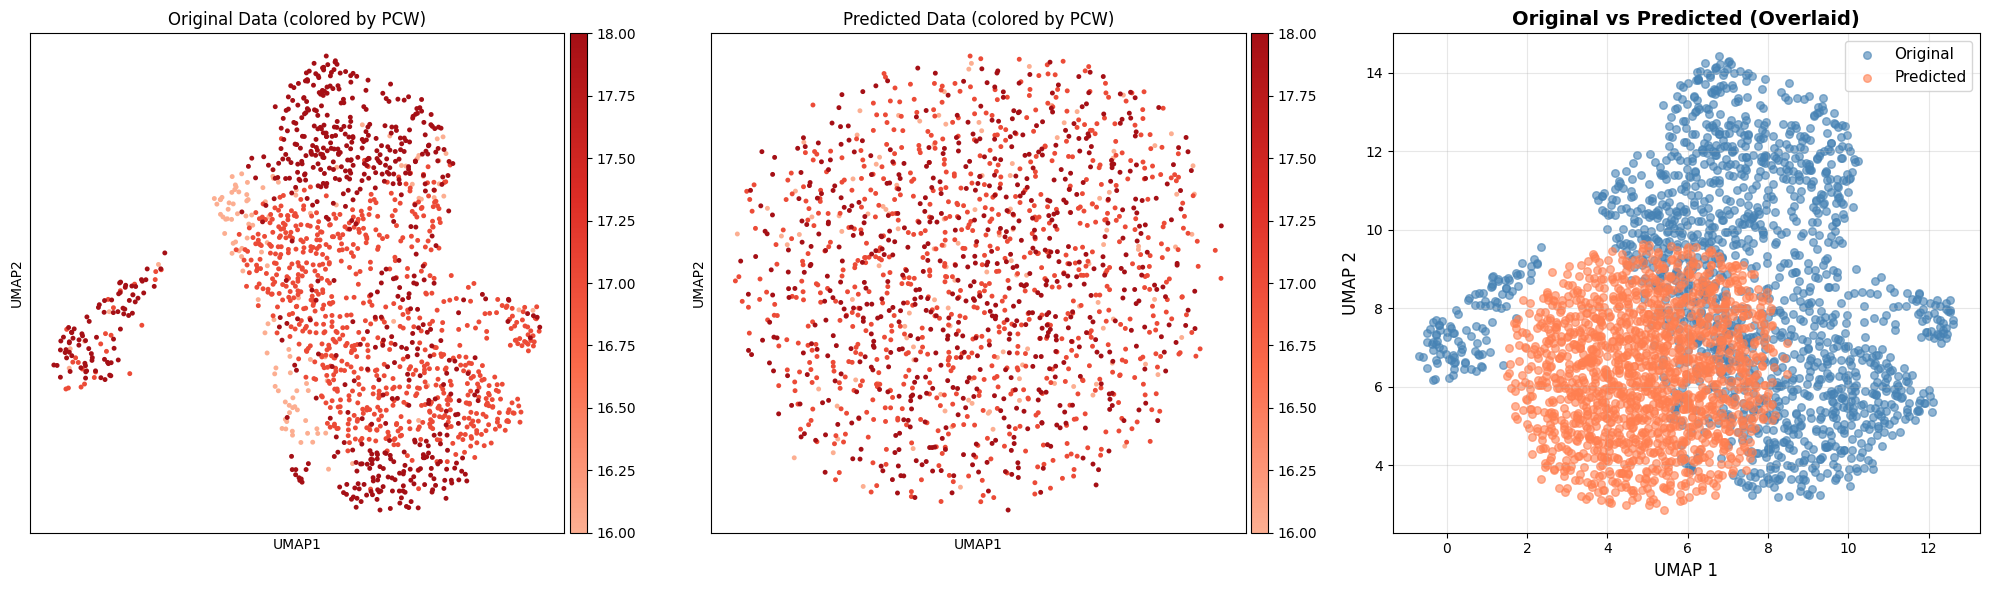

✅ UMAP comparison plots saved (PCW 16=white, 18=red)


In [38]:
print("Plotting UMAP comparison...")

# Create custom white-to-red colormap
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# Define red colormap
colors = ['#fcae91', '#fb6a4a', '#de2d26', '#a50f15']
n_bins = 100
cmap_white_red = LinearSegmentedColormap.from_list('white_red', colors, N=n_bins)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Fixed PCW range: 16 (white) to 18 (red)
pcw_min = 16
pcw_max = 18

# Plot 1: Original data colored by PCW (white to red, normalized 16-18)
sc.pl.umap(adata_orig, color='pcw', cmap=cmap_white_red,
           title='Original Data (colored by PCW)',
           ax=axes[0], show=False, size=50, vmin=pcw_min, vmax=pcw_max)

# Plot 2: Predicted data colored by PCW (white to red, normalized 16-18)
sc.pl.umap(adata_pred, color='pcw', cmap=cmap_white_red,
           title='Predicted Data (colored by PCW)',
           ax=axes[1], show=False, size=50, vmin=pcw_min, vmax=pcw_max)

# Plot 3: Side-by-side comparison
# Plot original in blue, predicted in red
axes[2].scatter(adata_orig.obsm['X_umap'][:, 0],
                adata_orig.obsm['X_umap'][:, 1],
                c='steelblue', s=30, alpha=0.6, label='Original')
axes[2].scatter(adata_pred.obsm['X_umap'][:, 0],
                adata_pred.obsm['X_umap'][:, 1],
                c='coral', s=30, alpha=0.6, label='Predicted')
axes[2].set_xlabel('UMAP 1', fontsize=12)
axes[2].set_ylabel('UMAP 2', fontsize=12)
axes[2].set_title('Original vs Predicted (Overlaid)', fontsize=14, fontweight='bold')
axes[2].legend(loc='best', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./inference_results/umap_comparison.pdf", dpi=300, bbox_inches='tight')
plt.savefig("./inference_results/umap_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ UMAP comparison plots saved (PCW 16=white, 18=red)")

### ---
### Q3. The current results does not look good. Please tune the training model, to improve it as much as poosbile, and demonstrate improved metrics and visualization.

### ---
### Q4. What is missing in this training process that is important to model evaluation?